# OFDM

This notebook focuses on Orthogonal Frequency Division Multiplexing (OFDM). It provides an example implementation of a basic OFDM transmitter and receiver. We analyze the spectral properties of an OFDM signal and demonstrate that the symbol error rate in AWGN is identical to the theoretical limit. For a diespersive channel, we show that the cyclic prefix effectively removes inter-symbol interference.

<a href="https://colab.research.google.com/github/bepepa/digital_comms/blob/master/040_ofdm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> (Executable notebook)

<a href="https://nbviewer.org/format/slides/github/bepepa/digital_comms/blob/main/040_ofdm.ipynb"><img src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg" alt="Render nbviewer" /> </a> (read-only, slides view)

In [1]:
## Boilerplate instructions for importing NumPy and Matplotlib
# Import NumPy
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns_context = "notebook"
sns.set_theme(context=sns_context, style="ticks")

# proper labeling of plots
from matplotlib.ticker import EngFormatter

In [2]:
def random_symbols(A, N):
    """generate random symbols from the constellation A
    
    Inputs:
    A - np.ndarray of symbols in constellation, e.g., A = np.array([1, -1]) for BPSK
    N - number of random symbols to produce

    Returns:
    Numpy array of length N
    """
    return A[np.random.randint(len(A), size=N)]

In [3]:
from scipy import special

def Q(x):
    """Gaussian error integral"""
    return 0.5 - 0.5*special.erf(x/np.sqrt(2))

In [4]:
def MPE_decision_rule(Z, A):
    """Decide which symbol was most likely transmitted
    
    This function examines matched filter outputs (in vector Z) and for each element of Z selects the symbol 
    from constellation A that is closest.

    Inputs:
    Z - Vector of matched filter outputs
    A - Constellation

    Returns:
    Numpy array of the same length as Z
    """
    dec = np.empty_like(Z)

    for n in range(len(Z)):
        this_Z = Z[n]
        ind = np.argmin(np.abs(A-this_Z))
        dec[n] = A[ind]

    return dec

## OFDM Transmitter

An OFDM signal is a multi-carrier signal. Each OFDM subcarrier supports a narrowband, linearly modulated signal. We will assume that the information to be transmitted consists of a length-$L$ sequence of symbols $s_n$. To generate a baseband OFDM signal, the following steps are performed.


### Step 1: Serial-to-Parallel Conversion

In the first step, we convert the length-$L$ symbol sequence into consecutive blocks containing $M$-symbols. If necessary, the last block is padded with 0s to fill it to length-$M$.

In Python, we accomplish S/P conversion by reshaping the (possibly padded) vector holding symbols into a matrix with trailing dimension equal to $M$. This choice is compatible with how the FFT routine in NumPy works.



In [5]:
def serial_to_parallel(syms, M):
    """Convert a vector of symbols to a matrix with trailing dimension M
    
    Inputs:
    * syms - vector of information symbols
    * M - block size

    Returns:
    matrix of dimensions (*,M)
    """
    L = len(syms)
    K = L % M      # L mod M

    if K != 0:
        syms = np.append(syms, np.zeros(M-K))  # zero-padding

    return np.reshape(syms, (-1, M))           # -1 means: figure out first dimension

In [6]:
# quick check
L = 13
# make L random QPSK symbols
syms = (1 - 2*np.random.randint(2, size=L)) + 1j*(1 - 2*np.random.randint(2, size=L))
# this sequence is easier to follow
syms = np.arange(L)

# S/P with M symbols per block
M = 5
block_syms = serial_to_parallel(syms, M)
print("syms = ", syms)
print("block_syms = \n", block_syms)

syms =  [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
block_syms = 
 [[ 0.  1.  2.  3.  4.]
 [ 5.  6.  7.  8.  9.]
 [10. 11. 12.  0.  0.]]


### Step 2: Sub-carrier Mapping

In addition to what was discussed in class, a mechanism to select subcarriers is introduced. The goal is to select $M$ of the $N$ subcarriers that the (inverse) DFT provides. This facility can be used, for example, 

* to leave some subcarriers near the band edge unoccupied, or 
* to provide a flexible mechanism to control bandwidth, or
* to leave a subset of the subcarriers for use by other users; this facilitates multiple access referred to as OFDMA.

To indicate which subcarriers are occupied, we use a (boolean) vector of length $N$, where $N$ is the length of the FFT. This vector contains $M$ 1s to mark the subcarrier positions that will be used. The active subcarriers will be filled with the elements of a matrix of symbols.

Recall that the (I)FFT assumes subcarrier numbers from $0$ to $N-1$, i.e., from $f=0$ to $f=f_s$. Therefore, the band-edges are located in the center of the IFFT input.

In [7]:
def map_to_subcarriers(block_syms, active_sc):
    """Map a matrix of symbols to active subcarriers
    
    Inputs:
    * block_syms - matrix of symbols, dimension (*,N)
    * active_sc - length N vector that marks active subcarries with 1's 

    Returns:
    matrix of dimension (*,N)
    """
    # make an array to hold the result; figure out dimensions and data type
    N = len(active_sc)
    L = block_syms.shape[0]
    res = np.zeros((L,N), dtype=syms.dtype)

    res[:,np.equal(active_sc, 1)] = block_syms

    return res

In [8]:
# Quick check: we expand from 5 to 8 subcarriers
active = [1, 1, 1, 0, 0, 0, 1, 1]  # leave the middle subcarriers empty
block_sc = map_to_subcarriers(block_syms, active)

print("block_sc = \n", block_sc)

block_sc = 
 [[ 0  1  2  0  0  0  3  4]
 [ 5  6  7  0  0  0  8  9]
 [10 11 12  0  0  0  0  0]]


### Step 3: Inverse DFT

The heart of the OFDM transmitter is the inverse DFT, computed efficiently using an IFFT. The result of the IFFT is scaled by $\sqrt{N_{FFT}}$ to make the transform energy preserving; i.e., the energy of the input signal equals that of the output.

In [9]:
def idft(block_sc):
    """inverse DFT of matrix of symbols
    
    Inputs:
    block_sc - matrix of symbols (and empty subcarriers)

    Returns:
    matrix of the same size as the input
    """
    N_FFT = block_sc.shape[1]
    return np.fft.ifft(block_sc) * np.sqrt(N_FFT)

In [10]:
# Quick check
block_sig = idft(block_sc)

print(f"block_sig = \n", block_sig)

block_sig = 
 [[ 3.53553391+0.j          1.25      -1.10355339j -1.76776695-1.06066017j
  -1.25      -0.39644661j  0.        +0.j         -1.25      +0.39644661j
  -1.76776695+1.06066017j  1.25      +1.10355339j]
 [12.37436867+0.j          5.51776695-1.10355339j -3.53553391-1.06066017j
  -1.98223305-0.39644661j  1.76776695+0.j         -1.98223305+0.39644661j
  -3.53553391+1.06066017j  5.51776695+1.10355339j]
 [11.66726189+0.j          6.28553391+6.99264069j -0.70710678+3.8890873j
   0.78553391-1.49264069j  3.8890873 +0.j          0.78553391+1.49264069j
  -0.70710678-3.8890873j   6.28553391-6.99264069j]]


### Step 4: Insert Cyclic Prefix

To insert a cyclic prefix, the last $N_{CP}$ samples from each block are pre-pended to to the start of each block.

In [11]:
def insert_cyclic_prefix(block_sig, N_CP):
    """Insert cyclic prefix
    
    Inputs:
    block_sig - matrix of signal samples
    N_CP - length of cyclic prefix in samples

    Returns:
    signal matrix with cyclic prefix inserted; second dimension increases by N_CP
    """
    if N_CP > 0:
        return np.append(block_sig[:,-N_CP:], block_sig, axis=1)
    else:
        return block_sig

In [12]:
# Quick check
N_CP = 2
block_sig_cp = insert_cyclic_prefix(block_sig, N_CP)

print("block_sig_cp = ", block_sig_cp)
print("dimensions prior to CP: ", block_sig.shape)
print("dimensions after CP: ", block_sig_cp.shape)

block_sig_cp =  [[-1.76776695+1.06066017j  1.25      +1.10355339j  3.53553391+0.j
   1.25      -1.10355339j -1.76776695-1.06066017j -1.25      -0.39644661j
   0.        +0.j         -1.25      +0.39644661j -1.76776695+1.06066017j
   1.25      +1.10355339j]
 [-3.53553391+1.06066017j  5.51776695+1.10355339j 12.37436867+0.j
   5.51776695-1.10355339j -3.53553391-1.06066017j -1.98223305-0.39644661j
   1.76776695+0.j         -1.98223305+0.39644661j -3.53553391+1.06066017j
   5.51776695+1.10355339j]
 [-0.70710678-3.8890873j   6.28553391-6.99264069j 11.66726189+0.j
   6.28553391+6.99264069j -0.70710678+3.8890873j   0.78553391-1.49264069j
   3.8890873 +0.j          0.78553391+1.49264069j -0.70710678-3.8890873j
   6.28553391-6.99264069j]]
dimensions prior to CP:  (3, 8)
dimensions after CP:  (3, 10)


### Step 5: Parallel-to-Serial Conversion

The final processing step is to concatenate the signal blocks and turn them into a vector.

In [13]:
def parallel_to_serial(block_sig):
    """convert a matrix of signal samples into a vector
    
    Inputs:
    block_sig - matrix of signal samples

    Returns:
    vector of signal samples
    """
    return np.reshape(block_sig, -1)  # -1 means: figure out how many samples

In [14]:
# quick check
sig = parallel_to_serial(block_sig_cp)

print("sig = ", sig)
print("signal has {:d} samples".format(len(sig)))

sig =  [-1.76776695+1.06066017j  1.25      +1.10355339j  3.53553391+0.j
  1.25      -1.10355339j -1.76776695-1.06066017j -1.25      -0.39644661j
  0.        +0.j         -1.25      +0.39644661j -1.76776695+1.06066017j
  1.25      +1.10355339j -3.53553391+1.06066017j  5.51776695+1.10355339j
 12.37436867+0.j          5.51776695-1.10355339j -3.53553391-1.06066017j
 -1.98223305-0.39644661j  1.76776695+0.j         -1.98223305+0.39644661j
 -3.53553391+1.06066017j  5.51776695+1.10355339j -0.70710678-3.8890873j
  6.28553391-6.99264069j 11.66726189+0.j          6.28553391+6.99264069j
 -0.70710678+3.8890873j   0.78553391-1.49264069j  3.8890873 +0.j
  0.78553391+1.49264069j -0.70710678-3.8890873j   6.28553391-6.99264069j]
signal has 30 samples


### Transmitter Object

For convenience, we define a class to represent an OFDM transmitter. The transmitter class wraps the above functions. The class is used like this:

``` Python
# instantiate an OFDM_Transmitter object ...
tx = OFDM_Transmitter(N_CP, active)
# ... and use it to convert a sequence of symbols into a signal
sig = tx(syms)
```

where `N_CP`, `active`, and `syms` are described above.

In [15]:
class OFDM_Transmitter():
    """OFDM transmitter class
    
    Parameters:
    N_CP - length of cyclic prefix
    active_sc - length N_FFT vector marking active subcarriers

    Example:
    # create a transmitter object
    tx = OFDM_Transmitter(N_CP, active_sc) 

    # pass symbols to tx object to generate signal
    sig = tx(syms)
    """
    def __init__(self, N_CP, active):
        self.N_CP = N_CP
        self.active = active
        self.N_FFT = len(active)

        self.M = int(np.sum(active))  # number of active subcarriers

    def __call__(self, syms):
        block_syms = serial_to_parallel(syms, self.M)
        block_sc = map_to_subcarriers(block_syms, self.active)
        block_sig = idft(block_sc)
        block_sig_cp = insert_cyclic_prefix(block_sig, self.N_CP)
        return parallel_to_serial(block_sig_cp)

In [16]:
# verify that we get the same result as with step-by-step
tx = OFDM_Transmitter(N_CP, active)
if np.allclose(sig, tx(syms)):
    print("Got same signal")

Got same signal


## OFDM Receiver

The OFDM receiver performs the functions of the transmitter in reverse order. 

### S/P conversion and Removal of Cyclic Prefix
The initial serial-to-parallel conversion must convert the signal vector into a matrix with second dimesnion equal to $N + N_{CP}$, where $N$ is the length of the FFT. The function `serial_to_parallel` can perform this task.

Next, the cyclic prefix must be stripped off. This involves simply removing the first $N_{CP}$ samples from each signal block.


In [17]:
def strip_cyclic_prefix(block_sig_cp, N_CP):
    """remove the leading N_CP samples from each signal block
    
    Inputs:
    block_sig_cp - matrix of signal blocks with cyclic prefix
    N_CP - length of cyclic prefix in samples

    Returns:
    matrix of signal blocks without cyclic prefix
    """
    return block_sig_cp[:, N_CP:]

In [18]:
# Quick check
N = len(active)  
rx_block_sig_cp = serial_to_parallel(sig, N + N_CP)
rx_block_sig = strip_cyclic_prefix(rx_block_sig_cp, N_CP)

if np.allclose(block_sig, rx_block_sig):
    print("Matches signals at transmitter")

Matches signals at transmitter


### DFT

The inverse operation to the IFFT performed at the transmitter is a DFT which can be carried out computationally efficiently using the FFT. The result of the FFT is scaled by $1/\sqrt{N_{FFT}}$ to make the transform energy preserving; i.e., the energy of the input signal equals that of the output.

In [19]:
def dft(block_sig):
    """ DFT of matrix of signal blocks
    
    Inputs:
    block_sig - matrix of signals

    Returns:
    matrix of the same size as the input
    """
    N_FFT = block_sig.shape[1]
    return np.fft.fft(block_sig) * 1/np.sqrt(N_FFT)

In [20]:
# Quick check
rx_block_sc = dft(rx_block_sig)

if np.allclose(block_sc, rx_block_sc):
    print("Matches subcarrier symbols at transmitter")

Matches subcarrier symbols at transmitter


### Removal of empty subcarriers and P/S conversion

The final two steps in the receiver processing chain remove the inactive, empty subcarriers and then convert the matrix of symbol blocks back into a sequence. For the latter operation, the existing `parallel_to_serial` function can be re-used.

Note: when the channel is dispersive an **equalizer** must be inserted either before or between these two steps.

In [21]:
def remove_inactive_subcarriers(block_sc, active_sc):
    """Extract symbols from active subcarriers
    
    Inputs:
    block_sc - matrix of symbols and empty subcarriers
    active_sc - length N vector that marks active subcarries with 1's 

    Returns:
    Matrix of symbols without empty subcarriers
    """
    return block_sc[:,np.equal(active_sc, 1)]

In [22]:
# Quick check
rx_block_syms = remove_inactive_subcarriers(rx_block_sc, active)
rx_syms = parallel_to_serial(rx_block_syms)

# minor problem, we need to know how many symbols were sent (b/c of zero padding)
if np.allclose(syms, rx_syms[:len(syms)]):
    print("received symbols match transmitted symbols")

received symbols match transmitted symbols


### Receiver Object

For convenience, we define a class to represent an OFDM receiver. The receiver class wraps the above functions. The class is used like this:

``` Python
# instantiate an OFDM_Receiver object ...
rx = OFDM_Receiver(N_CP, active)
# ... and use it to convert a received signal into a sequence of (soft-decision) symbols;
# these must still be passed through the decision rule
syms = rx(sig, N_syms)
```

where `N_CP`, `active`, and `sig` are described above. `N_syms` is the number of symbols to receive; this must be known since the transmitter may have zero-padded the symbol sequence.

In [23]:
class OFDM_Receiver():
    """OFDM receiver class
    
    Parameters:
    N_CP - length of cyclic prefix
    active_sc - length N_FFT vector marking active subcarriers

    Example:
    # create a receiver object
    rx = OFDM_Receiver(N_CP, active_sc) 

    # pass signal to rx object to recover symbols; 
    # number of symbols to receive must be provided, unless there was no zero padding.
    syms = rx(sig, N_syms)
    """
    def __init__(self, N_CP, active):
        self.N_CP = N_CP
        self.active = active
        self.N_FFT = len(active)

        self.M = np.sum(active)  # number of active subcarriers

    def __call__(self, sig, N_syms=None):
        block_sig_cp = serial_to_parallel(sig, self.N_FFT + self.N_CP)
        block_sig = strip_cyclic_prefix(block_sig_cp, self.N_CP)
        block_sc = dft(block_sig)
        block_syms = remove_inactive_subcarriers(block_sc, self.active)
        syms = parallel_to_serial(block_syms)

        if N_syms is None:
            N_syms = len(syms)

        return syms[:N_syms]

In [24]:
# Round-trip test without noise
N_syms = 10000

# 128 subcarriers with 96 of them occupied
N_FFT = 128
N_active = 96
active = np.ones(128)
active[N_active//2 : -N_active//2] = 0 # gap in the center (maps to band-edges)
N_CP = 6

# define a normalized QPSK constellation
A = np.array([1+1j, 1-1j, -1+1j, -1-1j]) / np.sqrt(2) 

# generate random symbols
syms = random_symbols(A, N_syms)

# instantiate tx and rx objects
tx = OFDM_Transmitter(N_CP, active)
rx = OFDM_Receiver(N_CP, active)

sig = tx(syms)
if np.allclose(rx(sig, N_syms), syms):
    print("all symbols received correctly")

all symbols received correctly


### Questions:

Let the OFDM transmitter be characterized by an FFT length of $N$ and the number of active sub-carriers is $M \leq N$. The cyclic prefix is $N_{CP}$. 

1. How many samples does the transmitted signal have when $L$ symbols are sent?
2. When the sample rate of the DAC is $f_s$, what is the frequency spacing between adjacent subcarriers?
3. Assume that the $N-M$ inactive subcarriers are located at the band edge. What is the occupied bandwidth of the signal?
4. How long is each OFDM symbol, including cyclic prefix?

### PAPR

A well-known drawback of OFDM is its large peak-to-average-power-ratio (PAPR). PAPR is the ratio of the maximum power, $\max |s(t)|^2$, amd the average power, $\frac{1}{T_0} \int_0^{T_0} |s(t)|^2 \,dt$.

For the signal `sig` generated above, we can estimate PAPR as follows:

In [25]:
# estimate PAPR
s_sq = np.real(sig*sig.conj())
PAPR = np.max(s_sq) / np.mean(s_sq)

print("PAPR is {:4.2f}dB".format(PAPR))

PAPR is 12.11dB


This is a large PAPR value. With single-carrier modulation, it is possible to keep PAPR much closer to 0dB. An approximate value for the PAPR is $\sqrt{M}$, where $M$ is the number of active subcarriers.

The fundamental reason for the large PAPR is that the sum of the narrowband signals yields a signal that appears noise-like (see plot below).

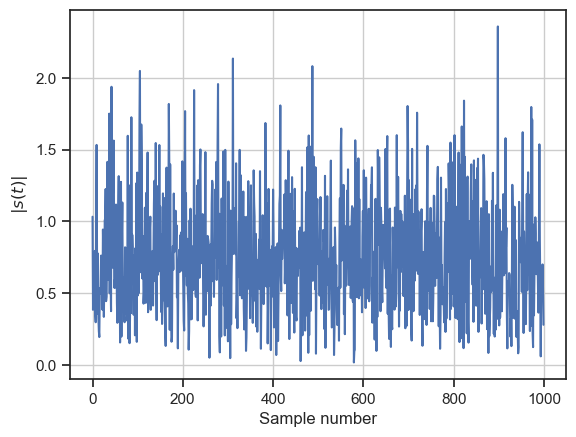

In [26]:
# plot the magnitude of OFDM signal
plt.plot(np.abs(sig[:1000]))
plt.grid()
plt.xlabel('Sample number')
plt.ylabel('$|s(t)|$')

plt.show()

## Spectral analysis of transmitted OFDM signal

With the transmitted signal `sig` in hand, we can estimate the power spectral density of the transmitted signal.

The signal uses $N_{FFT}=128$ subcarriers of which the central $M=96$ are occupied.

We assume (arbitrarily) that the sampling rate of the signal is 2MHz.

With these assumptions, the bandwidth of the signal will be
$$
    W = f_s \cdot \frac{M}{N_{FFT}} = \text{1.5MHz}
$$

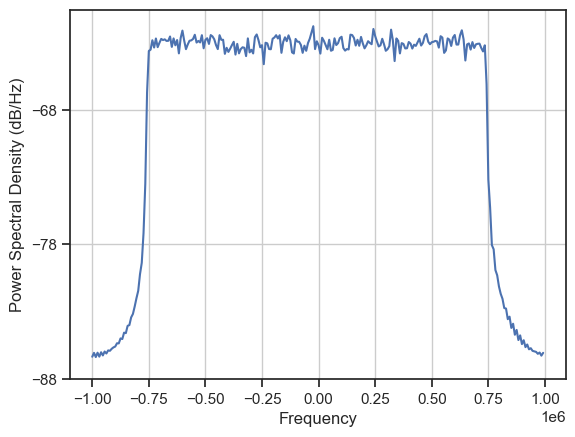

In [27]:
# estimate the PSD of the transmitted signal
plt.psd(sig, 256, 2e6)
plt.show()

The estimated PSD is consistent with our expectations:

* the central 1.5MHz of the band are occupied,
* the center of the band shows a flat spectrum

Note that the spectrum does not decay very rapidly at the band-edges; after all we're using rectangular pulse-shaping!


## Error Rate Simulation

As before, we simulate the symbol error rate of our OFDM transmitter and receiver. We still restrict ourselves to AWGN channels, i.e., channels without dispersion.

Since we do not have channel dispersion, for the initial simulation the cyclic prefix is $N_{CP}=0$.

In [28]:
# parameters
# 128 subcarriers with 96 of them occupied
N_FFT = 128
N_active = 96
active = np.ones(128)
active[N_active//2 : -N_active//2] = 0 # gap in the center (maps to band-edges)
N_CP = 0

# channel (AWGN)
SNR_dB = 10
SNR = 10**(SNR_dB/10)

A = np.array([1+1j, 1-1j, -1+1j, -1-1j]) / np.sqrt(2) # define a normalized QPSK constellation
N = N_active * 64                    # number of symbols per OFDM burst

# simulation parameters
max_bursts = 1000
max_errors = 400

N_bursts = 0
N_errors = 0

# instantiate tx and rx
tx = OFDM_Transmitter(N_CP, active)
rx = OFDM_Receiver(N_CP, active)

In [29]:
# the Monte Carlo loop
while N_bursts < max_bursts and N_errors < max_errors:
    # Transmitter
    sym = random_symbols(A, N)
    ss = tx(sym)
    # make sure that the signal has unit energy per symbol
    ss = ss * np.sqrt(N)/np.linalg.norm(ss)
    # Channel
    rr = ss + np.sqrt(0.5 * 1/SNR) * (np.random.randn(len(ss)) + 1j*np.random.randn(len(ss)))
    # receiver
    Z = rx(rr)
    dec = MPE_decision_rule(Z, A) # Z[:N] trims extra samples from the filter transient

    # update simulation statistics
    N_bursts += 1
    N_errors += np.sum(np.not_equal(dec, sym))

print("Found {:d} errors in {:d} symbols; estimated symbol error rate {:8.6f}".format(N_errors, N_bursts*N, N_errors/(N*N_bursts)))
print("The exact value for the symbol error rate is: {:8.6f}".format(2*Q(np.sqrt(SNR)) - Q(np.sqrt(SNR))**2))

Found 409 errors in 245760 symbols; estimated symbol error rate 0.001664
The exact value for the symbol error rate is: 0.001565


The symbol error rate is just the symbol error rate for QPSK over AWGN channels. This should not be surprising as there is no transmitter-induced (orthogonal signals) or channel-induced ISI. The only signal corruption is from AWGN.

The story changes slightly when we include a cyclic prefix. The cyclic prefix consumes energy that is not used for making signal decisions. Therefore, the (useful) energy per symbol decreases (usually slightly); specifically SNR decreases by a factor equal to $\frac{N_{FFT}}{N_{FFT}+N_{CP}}$. To make this point obvious, we set $N_{CP}$ to a fairly large value ($N_{CP}=N_{FFT}/4=32$); approximately 1dB SNR loss. 

*Remark:* In the absence of channel dispersion, we could try to include the cyclic prefix in the receiver processing. However, over the period covering both the symbol and the cyclic prefix subcarriers are not (quite) orthogonal. That induces ISI between subcarriers, this is called inter-carrier interference (ICI).

In [30]:
# parameters - only change N_CP
N_CP = N_FFT // 4

# reset simulation counters
N_bursts = 0
N_errors = 0

# instantiate tx and rx with changed N_CP
tx = OFDM_Transmitter(N_CP, active)
rx = OFDM_Receiver(N_CP, active)

In [31]:
# the Monte Carlo loop
while N_bursts < max_bursts and N_errors < max_errors:
    # Transmitter
    sym = random_symbols(A, N)
    ss = tx(sym)
    # make sure that the signal has unit energy per symbol
    ss = ss * np.sqrt(N)/np.linalg.norm(ss)
    # Channel
    rr = ss + np.sqrt(0.5 * 1/SNR) * (np.random.randn(len(ss)) + 1j*np.random.randn(len(ss)))
    # receiver
    Z = rx(rr)
    dec = MPE_decision_rule(Z, A) # Z[:N] trims extra samples from the filter transisent

    # update simulation statistics
    N_bursts += 1
    N_errors += np.sum(np.not_equal(dec, sym))

print("Found {:d} errors in {:d} symbols; estimated symbol error rate {:8.6f}".format(N_errors, N_bursts*N, N_errors/(N*N_bursts)))
SNR_new = SNR * N_FFT/(N_CP+N_FFT)
print("Effective SNR is {:4.2f}dB".format(10*np.log10(SNR_new)))
print("The exact value for the symbol error rate is: {:8.6f}".format(2*Q(np.sqrt(SNR_new)) - Q(np.sqrt(SNR_new))**2))

Found 422 errors in 92160 symbols; estimated symbol error rate 0.004579
Effective SNR is 9.03dB
The exact value for the symbol error rate is: 0.004672


## Channel Dispersion

A primary benefit of OFDM is its resilience to channel dispersion. 

Since the individual subcarrier signals are narrowband, it is possible to ensure that the symbol period $T$ is much greater than the delay spread $\tau_h$.

The symbol period (without cyclic prefix) is equal to
$$
T = \frac{N_{FFT}}{f_s}.
$$
Hence, the requirement $T \gg \tau$ translates into
$$
N_{FFT} \gg f_s \tau_h.
$$
Notice that $f_s \tau$ is the delay spread in sample periods.

The goal of inserting a cyclic prefix of $N_{CP}$ samples is to confine the transient at the symbol boundaries to the cyclic extension. This implies that
$$
    N_{CP} \gtrsim \lceil f_s \tau_h \rceil.
$$

### Illustration - Cyclic prefix

Assume that the delay spread covers 3 symbol periods, i.e., $\lceil f_s \tau_h \rceil = 3$. Specifically, we assume that the sampled impulse response of the channel is
$$
    h[n] = h(n/f_s) = [1, \frac{1}{2}j, -\frac{1}{4}] \cdot \sqrt{\frac{16}{21}}.
$$
This channel has unit energy (i.e., does not introduce a gain) because $\sum_n |h[n]|^2 = 1$.

The frequency response of this channel at the subcarrier frequencies is 
$$
    H(e^{j2\pi k/N_{FFT}}) = \sum_n h[n] \cdot e^{-j2\pi nk/N_{FFT}} = 
    \sqrt{\frac{16}{21}} \cdot \left(1 + \frac{1}{2}j e^{-j2\pi k/N_{FFT}} - \frac{1}{4} e^{-j4\pi k/N_{FFT}}\right)
$$

Magnitude and phase of this frequency response are plotted below.

<>:11: SyntaxWarning: invalid escape sequence '\p'
<>:11: SyntaxWarning: invalid escape sequence '\p'
/var/folders/zw/1527vjzj6h76ccrkys88lsqr0000gp/T/ipykernel_48989/646640667.py:11: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel('$|H(e^{j2\pi k/N_{FFT}})|$')


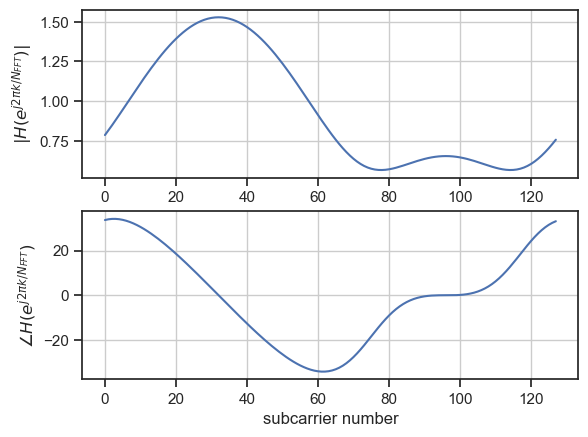

In [32]:
hh = np.array([1, 0.5j, -0.25]) * np.sqrt(16/21)
w = np.arange(N_FFT)/N_FFT * 2 * np.pi 
HH = np.zeros_like(w, dtype=complex)

for n in range(len(hh)):
    HH += hh[n] * np.exp(-1j * n * w)

plt.subplot(211)
plt.plot(np.arange(N_FFT), np.abs(HH))
plt.grid()
plt.ylabel(r'$|H(e^{j2\pi k/N_{FFT}})|$')

plt.subplot(212)
plt.plot(np.arange(N_FFT), np.angle(HH) * 180/np.pi)
plt.grid()
plt.ylabel(r'$\angle H(e^{j2\pi k/N_{FFT}})$')
plt.xlabel('subcarrier number')

plt.show()

This is a fairly benign channel. However, subcarriers near $k=0$, $k=60$, and $k=128$ experience phase changes of $\pm 30^o$. 

To communicate over this channel, we use an OFDM signal with $N_{FFT} = 128$ and $N_{CP}=4$. All subcarriers are active.

In [33]:
# parameters
N_FFT = 128
N_active = N_FFT
active = np.ones(N_FFT)
N_CP = 4

# channel (AWGN)
SNR_dB = 20
SNR = 10**(SNR_dB/10)

# channel dispersion
hh = np.array([1, 0.5j, -0.25]) * np.sqrt(16/21)

A = np.array([1+1j, 1-1j, -1+1j, -1-1j]) / np.sqrt(2) # define a normalized QPSK constellation
N = N_active * 128                   # number of symbols per OFDM burst


# instantiate tx and rx
tx = OFDM_Transmitter(N_CP, active)
rx = OFDM_Receiver(N_CP, active)

In [34]:
# Transmitter
sym = random_symbols(A, N)
ss = tx(sym)

# Channel
# dispersion
rr = np.convolve(ss, hh)
# noise
rr = rr[:len(ss)] + np.sqrt(0.5 * 1/SNR) * (np.random.randn(len(ss)) + 1j*np.random.randn(len(ss)))

# receiver
Z = rx(rr)

dec = MPE_decision_rule(Z, A)
if np.sum(np.not_equal(dec, sym)) > 0:
    print("Found {:d} symbol errors.".format(np.sum(np.not_equal(dec, sym)) ) )
else:
    print("no symbol errors")

Found 32 symbol errors.


Despite high SNR (SNR = 20dB), there are multiple symbol errors. 

The cyclic prefix by itself does not prevent these symbol errors!

To understand what causes these errors, we need to look at the OFDM demodulator outputs `Z` separately for each subcarrier.

The OFDM demodulator outputs for subcarrier $k$ are located at positions $k + n \cdot N_{FFT}$ in the vector `Z`.

First, we look at subcarrier $k=90$. The frequency response at this subcarrier is approximately $0.6 \cdot e^{j0}$, i.e., there is no phase shift at this subcarrier.

We plot a scatter plot of received symbols in the complex plane.

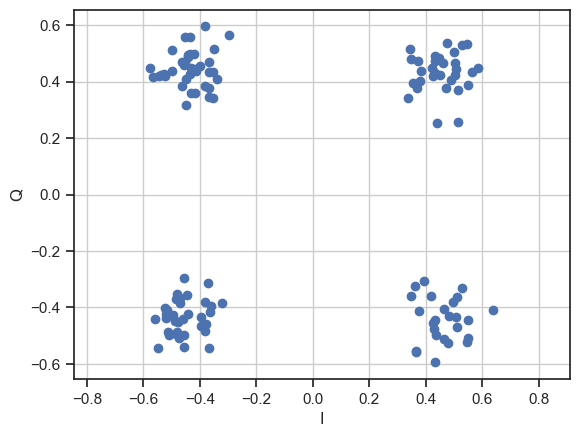

In [35]:
k = 90
Z_k = Z[k::N_FFT]

plt.plot(Z_k.real, Z_k.imag, 'o')
plt.grid()
plt.axis('equal')

plt.xlabel('I')
plt.ylabel('Q')

plt.show()

For this subcarrier, the QPSK constellation is clearly discernible.

The constellation has shrunk (by 60%) which increases the error probability; the SNR on this subcarrier is approximately 4dB reduced.

However at SNR=20dB, no errors occur on this subcarrier.

Next, we look at subcarrier $k=0$. The frequency response at this subcarrier is approximately $0.8 \cdot e^{j33^o}$, i.e., there is a phase shift of nearly $45^o$ at this subcarrier.


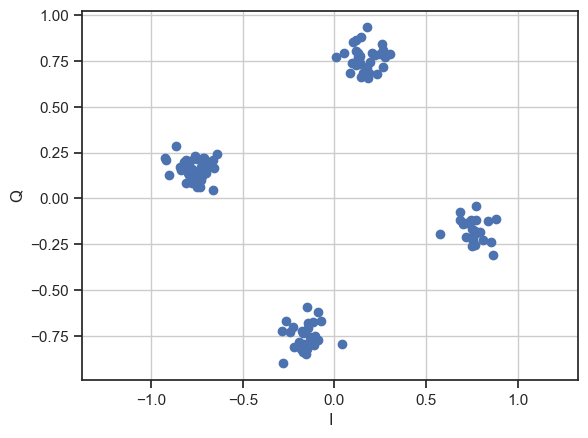

In [36]:
k = 0
Z_k = Z[k::N_FFT]

plt.plot(Z_k.real, Z_k.imag, 'o')
plt.grid()
plt.axis('equal')

plt.xlabel('I')
plt.ylabel('Q')

plt.show()

For this subcarrier, the QPSK constellation is still clearly discernible. However it is rotated by $33^o$. It is also slightly shrunk.

The phase rotation causes the constellation clusters to be very close to the decision boundary (the axes).

A few of the constellation points fall on the wrong side of the decision boundaries. This causes errors!

#### We still need an equalizer

The examples above illustrate that a cyclic prefix does **not** prevent the impact of channel dispersion on the received signal.

On each subcarrier, we still see:

* amplitude scaling
* phase rotation
* both are determined by the frequency response $H(e^{j2\pi k/N_{FFT}})$ for subcarrier $k$

The effect of the channel is fairly easy to compensate: just divide the OFDM modulator outputs (`Z`) on subcarrier $k$ by $H(e^{j2\pi k/N_{FFT}})$.

This is what a frequency domain equalizer does.

To underscore this point, let's remove the noise and produce a scatter plot affected only by dispersion

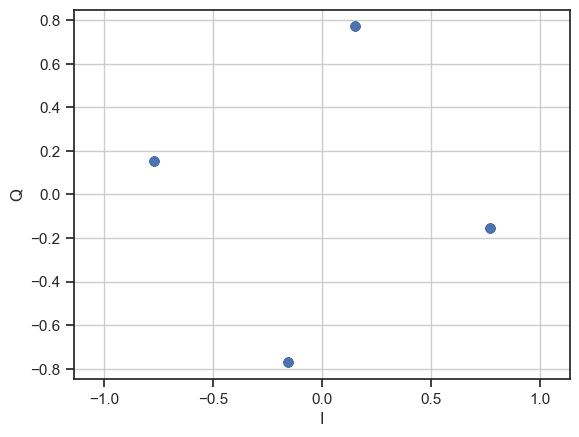

In [37]:
# channel (AWGN)
SNR_dB = 200  # essentially no noise
SNR = 10**(SNR_dB/10)

# Transmitter
sym = random_symbols(A, N)
ss = tx(sym)

# Channel
# dispersion
rr = np.convolve(ss, hh)
# noise
rr = rr[:len(ss)] + np.sqrt(0.5 * 1/SNR) * (np.random.randn(len(ss)) + 1j*np.random.randn(len(ss)))

# receiver
Z = rx(rr)

k = 0
Z_k = Z[k::N_FFT]

plt.plot(Z_k.real, Z_k.imag, 'o')
plt.grid()
plt.axis('equal')

plt.xlabel('I')
plt.ylabel('Q')

plt.show()


There are only four points but they are rotated and scaled from the original QPSK constellation. This rotation and scaling must be fixed by the equalizer to ensure that performance holds up with noise.

### Illustration - No Cyclic prefix

So, what does the cyclic prefix do for us, then?

Well, let's see what happens if we don't include it.

We pass a noise-free OFDM signal without cyclic prefix through the OFDM receiver and examine the constellation scatter plot for one of the subcarriers:

In [38]:
# changed parameters
N_CP = 0

# channel (AWGN)
SNR_dB = 200  # essentially no noise
SNR = 10**(SNR_dB/10)

# instantiate tx and rx with new N_CP
tx = OFDM_Transmitter(N_CP, active)
rx = OFDM_Receiver(N_CP, active)

In [39]:
# Transmitter
sym = random_symbols(A, N)
ss = tx(sym)

# Channel
# dispersion
rr = np.convolve(ss, hh)
# noise
rr = rr[:len(ss)] + np.sqrt(0.5 * 1/SNR) * (np.random.randn(len(ss)) + 1j*np.random.randn(len(ss)))

# receiver
Z = rx(rr)

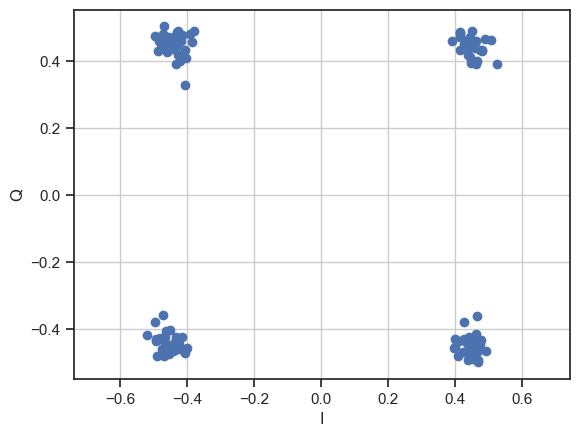

In [40]:
k = 90
Z_k = Z[k::N_FFT]

plt.plot(Z_k.real, Z_k.imag, 'o')
plt.grid()
plt.axis('equal')

plt.xlabel('I')
plt.ylabel('Q')

plt.show()

What the scatter plot above  shows is ISI: a small part of the prior symbol "spills" into the next symbol.

So, the benefit of the cyclic prefix is that it "traps" the intersymbol interference that occurs at the beginning of a symbol period.

However, the cyclic prefix can *not* prevent constellation scaling and rotation due to the frequency response of the channel - that requires an equalizer!